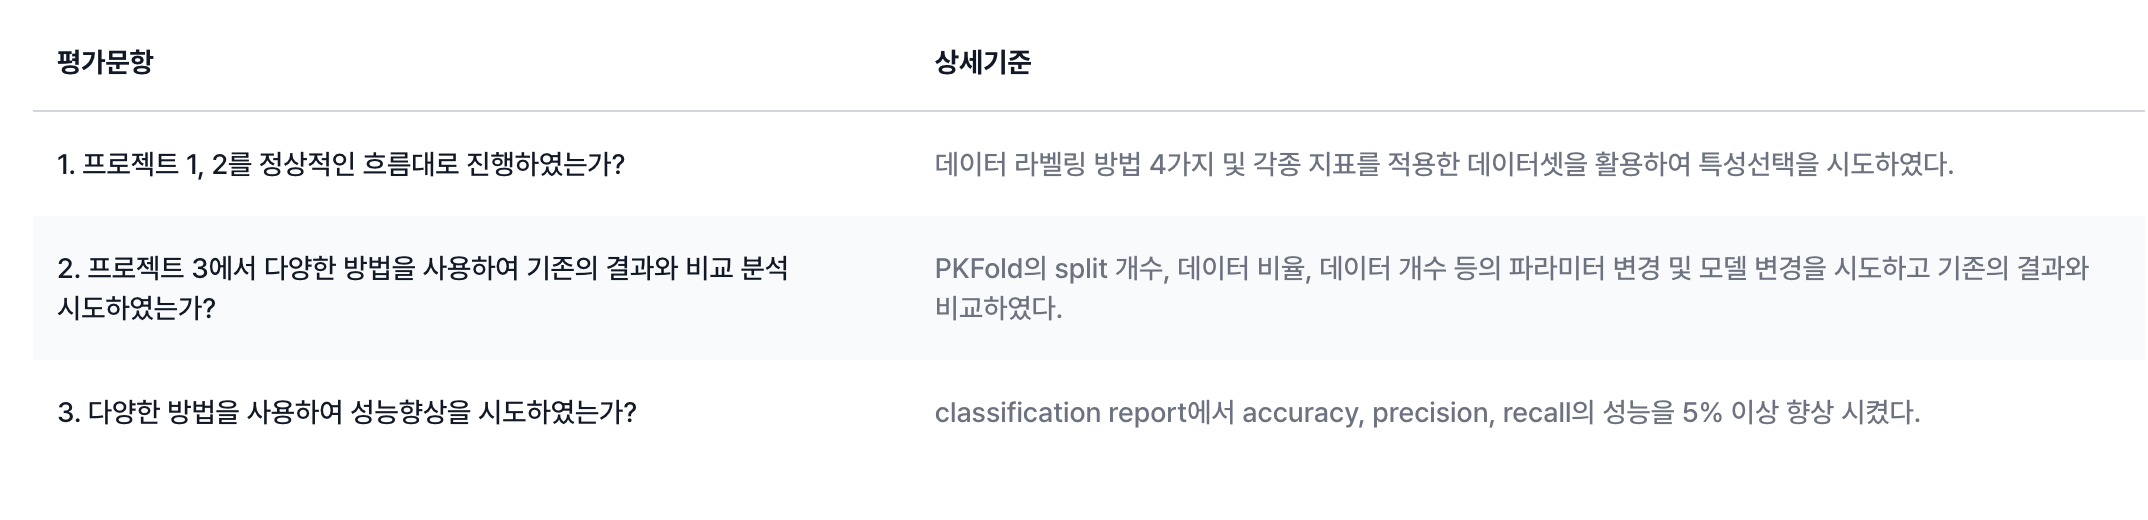

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

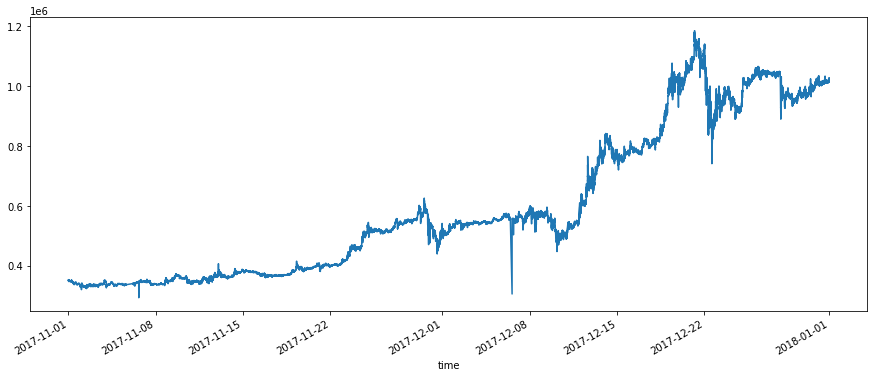

In [4]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot(figsize=(15,6))

## 1. Data Labeling

### ① Price Change Direction 적용하기

In [5]:
# window 지정
window = 7 # 앞서 사용한 window의 값은 10입니다.

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1) 
# modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)
# 데이터 활용을 위해 pd.Series를 사용합니다.

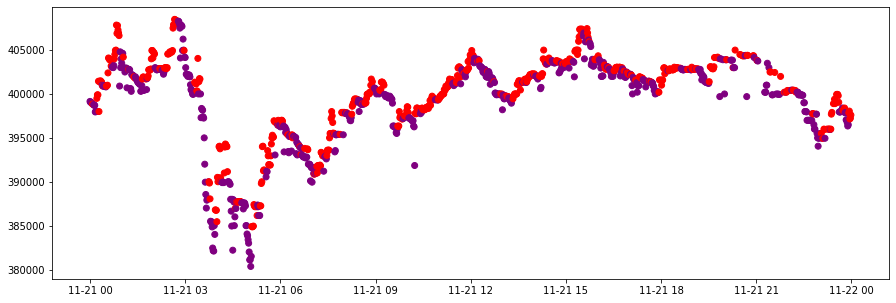

In [10]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']
# loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']
# loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'purple')
# np.where 사용

# 시각화하기
plt.figure(figsize=(15,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### ② Using Moving Average 적용하기

In [11]:
# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1) 

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

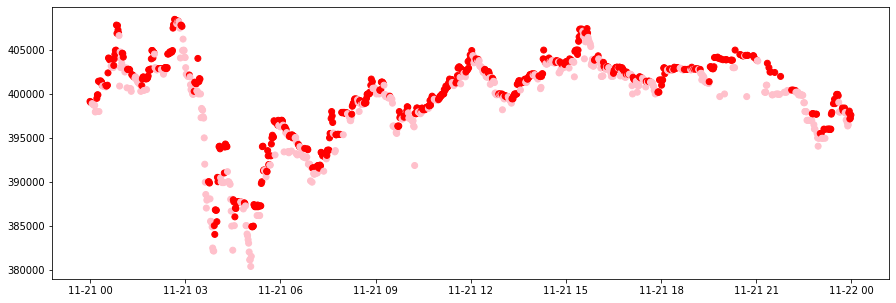

In [13]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'pink')

plt.figure(figsize=(15,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### ③ Local Min-Max 적용하기

In [15]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0] # ①
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val # ②
            maxes.append(max_value) # ③
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # ④
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False # ⑤
            n_cnt_max += 1 # ⑥
            if n_cnt_max >= wait:
                min_value = max_value # ⑦
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time':min_idxes,'local_min': mins }), pd.DataFrame.from_dict({'max_time':max_idxes,'local_max': maxes })

In [16]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

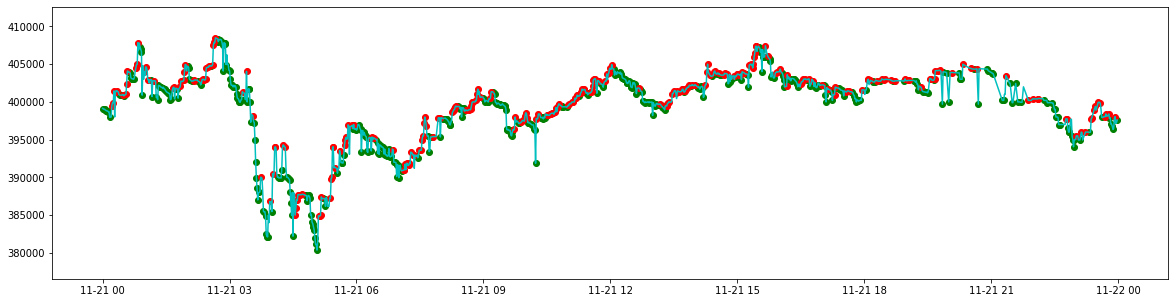

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='green')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

(376546.5, 412585.0)

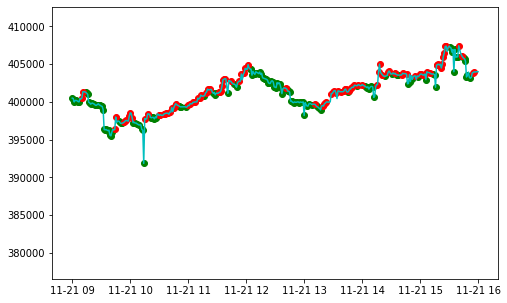

In [31]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='green')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

In [22]:
sub_data

time
2017-11-21 00:00:00    399150
2017-11-21 00:01:00    399050
2017-11-21 00:02:00    399050
2017-11-21 00:03:00    399000
2017-11-21 00:04:00    398900
                        ...  
2017-11-21 23:55:00    397850
2017-11-21 23:56:00    398050
2017-11-21 23:57:00    397150
2017-11-21 23:58:00    397250
2017-11-21 23:59:00    397600
Name: close, Length: 1301, dtype: int64

### ④ Trend Scanning 적용하기
- OLS는 회귀분석을 하는 경우 유용하게 사용할 수 있음
- 함수에서 ols.tvalue를 통해 t-value값을 사용할 수 있는 함수를 활용하여 추세(trend) 추정

In [32]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [33]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [37]:
modify_data

,open,high,low,close,volume
time,,,,,
2017-09-25 03:00:00,324500,325500,322000,324000,52.477251
2017-09-25 03:01:00,324000,324000,322500,324000,39.061889
2017-09-25 03:02:00,322500,324500,322500,324500,12.794000
2017-09-25 03:05:00,324000,324000,323000,324000,33.365246
2017-09-25 03:06:00,324000,325000,322500,324000,46.224544
...,...,...,...,...,...
2019-11-03 10:29:00,212650,212800,212600,212800,30.996276
2019-11-03 10:30:00,212800,212800,212600,212600,3.224132
2019-11-03 10:31:00,212600,212600,212400,212400,135.351681


In [38]:
molecule = modify_data['2018-12-01':'2018-12-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 41654/41654 [16:49<00:00, 41.27it/s]


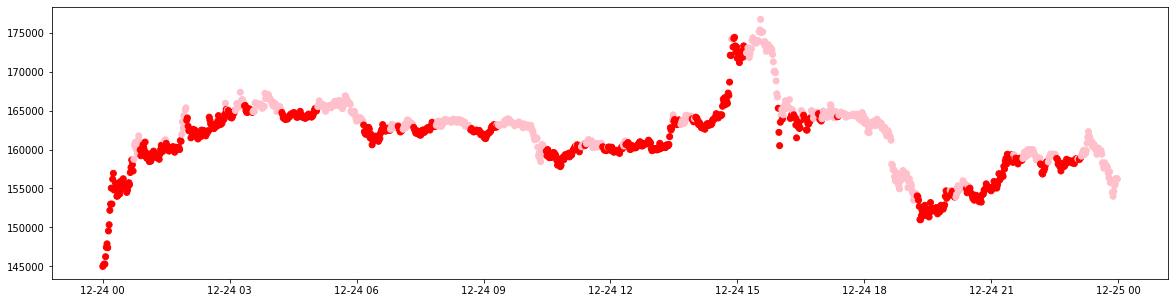

In [39]:
sub_data = modify_data.loc['2018-12-24', 'close']
c_sig = label['bin'].loc['2018-12-24']
c_sig['color'] = np.where(c_sig == 1, 'red', 'pink')

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

## 2. Feature Engineering

In [ ]:
# !pip install ta==0.9.0
# !pip install shap

In [40]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [41]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 편의상 1000개의 데이터만
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

- Technical Index 적용

In [42]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [43]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [44]:
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [45]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

### ③ Feature Selection methods 적용하기

In [46]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.046900,0.001977
volume_fi,0.043510,0.002283
volume_mfi,0.042475,0.002362
volume_sma_em,0.035347,0.001878
volume_vpt,0.023282,0.001534
volatility_atr,0.081083,0.003877
volatility_ui,0.051429,0.002460
trend_macd_diff,0.075006,0.003979
trend_adx,0.055283,0.002496
trend_trix,0.066156,0.002848


In [49]:
# MDA, Mean Decrease Accuracy
# svc_rbf = SVC(kernel='rbf', probability=True) 
# # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
# cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
# feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

rf = RandomForestClassifier(n_estimators=100) 
cv = KFold(n_splits=10)
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [50]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

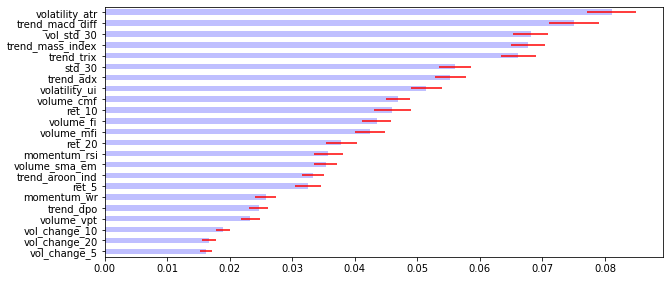

In [51]:
# plot_feature_importance 함수 사용하여 feat_imp, feat_imp_mda 확인

# feat_imp 확인
plot_feature_importance(feat_imp)

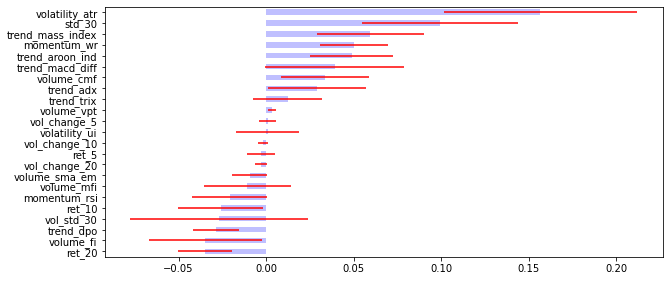

In [52]:
# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

In [53]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv) # RFECV 사용
rfe_fitted = rfe_cv.fit(X_sc, y) # fit 사용

In [54]:
# SFS, Sequential Feature Selection
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=2, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

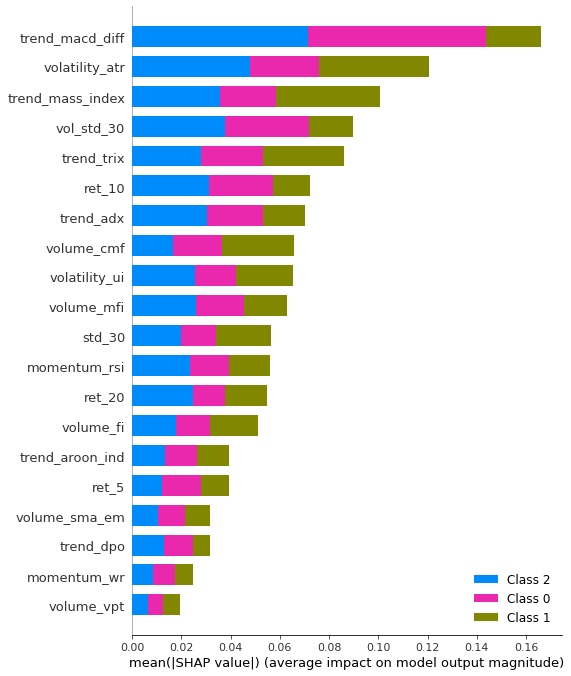

In [55]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

## 3. Model Traning

In [56]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [58]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

In [74]:
n_cv = 4
# 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

#### Q. n_cv=4로 지정한 이유
- 교차 검증(cross-validation) 폴드 수 지정
- 모델 성능 평가 및 일반화 능력 검증 기법

고려해야할 요소
- 데이터 크기
    - 데이터셋이 1000개의 샘플로 제한하였음
    - 교차 검증을 통해 모델의 일반화 능력을 평가하려면 충분한 데이터를 훈련과 검증에 모두 사용
    - n_cv = 4 : 각 교차 검증 단계에서 약 750개의 샘플을 훈련에 사용하고 250개의 샘플을 검증에 사용
        ⇢ 균형 잡힌 데이터 분할 가능, 모델 성능 안정적으로 평가
        
- 그 외 모델 복잡도, 성능 평가의 정밀도, 계산 효율성, 정보 누수 방지 등


- 모델 일반화 능력에 대한 평가를 더 정확히 하기 위한 목적으로 폴드 수 조정할 수 있음
    - 폴드 수를 늘리면 각 폴드에서 사용하는 훈련 데이터의 양이 줄어들지만, 평가가 더 많이 반복되므로 성능 평가의 신뢰성이 높아질 수 있다
    - 반대로 폴드 수를 줄이면 각 폴드에서 더 많은 데이터를 사용하여 모델을 학습시킬 수 있지만, 평가의 반복 횟수가 줄어들어 성능 평가의 신뢰성이 다소 감소할 수 있다


### 모델 적용

In [75]:
bc_params = {'n_estimators': [5, 10, 20, 30, 50, 100, 200],
             'max_features': [0.3, 0.5, 0.7, 0.9],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [1, 2, 3, 5, 8, 10],
             'bootstrap_features': [False, True]
            }

In [76]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [77]:
# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

In [78]:
# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [ ]:
# fit
gs_rfc.fit(train_x, train_y)

Fitting 4 folds for each of 2688 candidates, totalling 10752 fits


In [ ]:
# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

In [ ]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [ ]:
# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [ ]:
# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'b-.') # dash-dotted diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

### 회고

1. 모델 테스트 결과 \
    1) 교차 검증의 폴드수를 4 ⇢ 5로 변경
        - 비슷하나 성능이 다소 감소
        - 폴드수 변화만으로 성능을 올린 수는 없지만 고려해야 할 조건들을 새롭게 알게 됨
    2) 파라미터 다각화 
        - 1차 (class_weight='balanced', max_depth=3, max_features=None, min_samples_leaf=5), max_features=0.7, n_estimators=5)
        - 2차 (

이번 프로젝트에서 ROC와 AUC를 면밀히 이해하였습니다. 업비트에서 제공하는 이더리움 분봉 데이터를 활용하여 추세를 판단하는 이진 분류기를 구현했습니다. 이 과정에서 지도 학습 방식을 기반으로 한 분류 알고리즘을 적용했습니다.
- ROC curve : 모델이 다양한 임계값에서 어떻게 성능을 나타내는지 시각화하는 그래프. 참 양성 비율(True Positive Rate, TPR)에 대한 거짓 양성 비율(False Positive Rate, FPR)을 플로팅하여, 분류기 성능을 임계값 변화에 따라 평가
- Bagging : Bootstrap Aggregating - 여러 개 작은 결정 트리 훈련 후 그 결과를 합쳐 최종 결정을 내는 앙상블 기법. 이 방법으로 모델 분산을 줄이고, 과적합 방지하여 일반화 성능 향상 시킴
- GridsearchCV : 하이퍼파리미터 튜닝을 위해 사용되는 방법, 지정된 파라미터 그리드에 대해 교차 검증 수행하여 최적의 하이퍼파라미터 조합찾음. 이를 통해 배깅 분류기 성능 최대화 파라미터 설정 찾았음

하이퍼파라미터 튜닝 과정에서 파라미터를 다소 과하게 잡고 튜닝을 진행한 건지 시간이 생각보다 훨씬 오래 걸렸다. 그동안 무작정 다 해보는 식의 모델링을 하는 경향이 있었는데 점차 데이터가 복잡하고 커져가니 전체 시나리오부터 잘 설계해놓고 시도해보는 편이 좋을 것 같다.